#  K-means Clustering and Principal Component Analysis

## 1 K-means Clustering

"...you will implement the K-means algorithm and use it for image compression."

### 1.1 Implementing K-means

#### 1.1.1 Finding closest centroids

In [1]:
import scipy.io
import numpy as np
import math
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.misc import imread

In [2]:
# Load example dataset
data = scipy.io.loadmat('data/ex7data2.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [3]:
X = data['X']
X.shape

(300, 2)

300 examples of 2D data points

In [4]:
K = 3 # 3 centroids

# Initial centroid positions
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

In [5]:
def find_closest_centroids(X, centroids):
    '''
    Returns the closest centroids for every example in dataset X,
    where each row in X is a single example.
    Returned array idx  is an (m x 1) vector of centroid assignments
    (i.e. each entry in range [1..K]).
    '''
    
    idx = np.zeros([X.shape[0], 1])
    
    K = centroids.shape[0] # number of centroids
    m = X.shape[0] # number of examples
    
    for i in range(m):
        c = -1 # index of closest centroid
        dist_min = np.inf # distance to nearest centroid

        for k in range(K):
            dist = distance.euclidean(centroids[k], X[i]) 
            if dist < dist_min:
                dist_min = dist
                c = k
        
        idx[i] = c
    
    return idx

In [6]:
# Find the closest centroids for the examples in X
idx = find_closest_centroids(X, initial_centroids)

In [7]:
print('Closest centroids for the first 3 examples:')
print(idx[0:3])
print('Closest centroids should be 0, 2, 1 respectively')

# The exercise actually specifies 1, 3, 2, but since python
# uses zero-based indexing we should see 0, 2, 1.

Closest centroids for the first 3 examples:
[[ 0.]
 [ 2.]
 [ 1.]]
Closest centroids should be 0, 2, 1 respectively


#### 1.1.2 Computing centroid means

In [8]:
def compute_centroids(X, idx, K):
    '''
    Returns new centroids by computing the means of the data points assigned to each centroid.
    Parameters:
    -dataset X where each row is a single data point
    -a vector idx of centroid assignments for each example in X
    -the number of centroids K.
    '''

    m, n = X.shape # nuber and dimension of examples
    centroids = np.zeros([K, n])
   
    for k in range(K):
        C = np.sum(idx==k) # number of examples assigned to centroid k
        idx_k = (idx==k).astype(int) # binary array of examples assigned to centroid k
        X_k = X * idx_k # array of coordinates of examples assigned to centroid k

        # Calculate new centroid mean
        mu = (1/C) * np.sum(X_k, axis=0)
        centroids[k] = mu

    return centroids

In [9]:
centroids = compute_centroids(X, idx, K)

In [10]:
print('Centroids computed after initial finding of closest centroids:')
print(centroids)
print('\nExpected centroids:');
print('[ 2.428301 3.157924 ]');
print('[ 5.813503 2.633656 ]');
print('[ 7.119387 3.616684 ]');

Centroids computed after initial finding of closest centroids:
[[ 2.42830111  3.15792418]
 [ 5.81350331  2.63365645]
 [ 7.11938687  3.6166844 ]]

Expected centroids:
[ 2.428301 3.157924 ]
[ 5.813503 2.633656 ]
[ 7.119387 3.616684 ]


### 1.2 k-means on example dataset

In [11]:
# Run k-means on example dataset we already loaded

# Settings for running k-means
K = 3
max_iters = 10
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

In [12]:
def plot_k_means(X, idx, centroids_history, terminated=False):

    plt.figure(figsize=(8,6))
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=idx, cmap='rainbow')
    
    if terminated:
        plt.plot(centroids_history[:, :, 0], centroids_history[:, :, 1], 'x-', c='k')
    
    plt.show()

In [13]:
def run_k_means(X, initial_centroids, max_iters, plot_progress=False):
    '''
    Runs the k-means algorithm on data matrix X, with initial
    centroids initial_centroids, and maxmimum number of iterations
    max_iters. plot_progress is a true/false flag that 
    indicates if the function should plot its progress.
    
    Returns centroids, a (K x n) matrix of the computed centroids,
    and idx, a (m x 1) vector of centroid assignments.
    '''
    
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros([m, 1])

    centroids_history = np.zeros([max_iters+1, centroids.shape[0], centroids.shape[1]])
    centroids_history[0] = initial_centroids
    
    if plot_progress:
        print('Before clustering:')
        plot_k_means(X, idx, centroids_history)
    
    # Run k-means
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, K)
        centroids_history[i+1] = centroids

    if plot_progress:
        print('Clustering after', max_iters, 'iterations of k-means:')
        plot_k_means(X, idx, centroids_history, terminated=True)
        
    return centroids, idx

Before clustering:


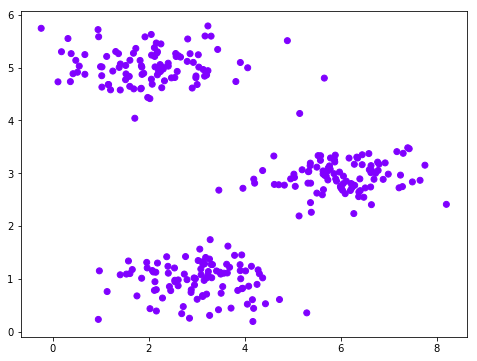

Clustering after 10 iterations of k-means:


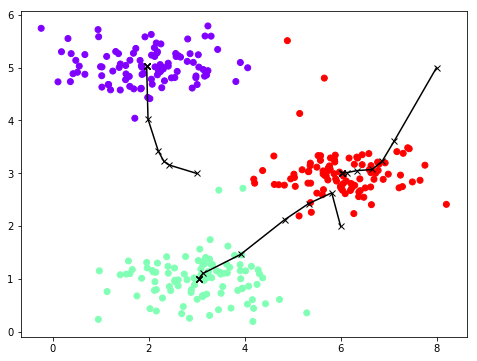

In [14]:
centroids, idx = run_k_means(X, initial_centroids, max_iters, plot_progress=True)

### 1.3 Random initialization

In [15]:
def k_means_init_centroids(X, K):
    
    '''
    Returns K random initial centroids to be
    used with the k-means clustering  on the dataset X.
    '''
    
    centroids = np.zeros([K, X.shape[1]])
    
    # Randomly reorder the indices of examples
    randidx = np.random.permutation(X.shape[0])

    # Take the first K examples as centroids
    centroids = X[randidx[:K], :]
    
    return centroids

Let's do it again using randomly-initialised centroids

Before clustering:


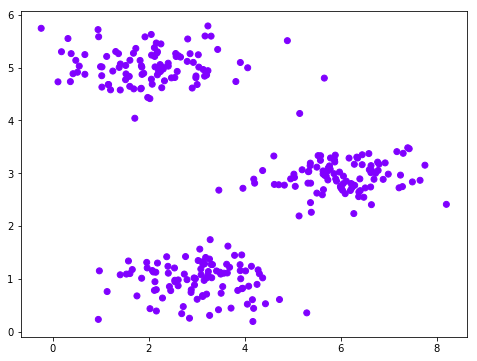

Clustering after 10 iterations of k-means:


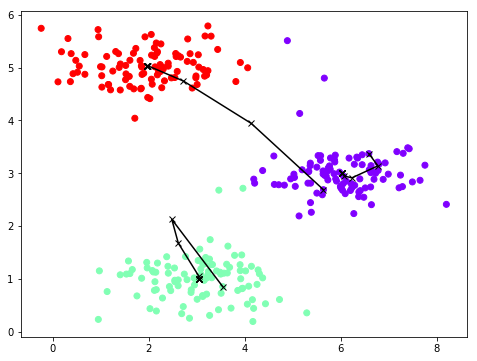

In [16]:
initial_centroids = k_means_init_centroids(X, K=3)
centroids, idx = run_k_means(X, initial_centroids, max_iters=10, plot_progress=True)

### 1.4 Image compression with K-means

We're going to compress a 24-bit colour image into a 4-bit (16-colour) image.

We will treat each pixel in the image as an example in a 3D space (one dimension each for red, green, blue), then use k-means clustering to find the 16 colours that best group (cluster) the pixels. We can then replace the 24-bit colour value of each pixel with it's cluster value, thus reducing the image to 16 colours.

#### 1.4.1 K-means on pixels

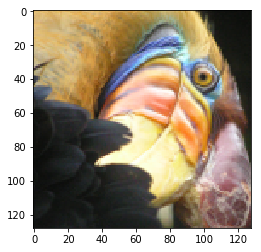

In [17]:
img = imread('data/bird_small.png')
plt.imshow(img)
plt.show()

In [18]:
# 'img' is a numpy array...
type(img)

numpy.ndarray

In [19]:
# ... of size 128x128, where each pixel has three values (0-255)
# for it's red, green and blue intensities
img.shape

(128, 128, 3)

In [20]:
A = img
A = A / 255 # divide by 255 so all colour values are in range 0-1.

In [21]:
# Reshape the image into an Nx3 matrix where N = number of pixels.
# Each row will contain the red, green and blue pixel values
# This gives us our dataset matrix X that we will use k-means on.

X = np.reshape(A, [A.shape[0] * A.shape[1], 3])
X.shape

(16384, 3)

In [22]:
# Run k-means
K = 16
max_iters = 10

initial_centroids = k_means_init_centroids(X, K)
centroids, idx = run_k_means(X, initial_centroids, max_iters)

In [23]:
idx = idx.flatten() # needs to be flat to be used as indices
idx = idx.astype(int) # needs to be int to be used as indices

# Recover compressed image
X_recovered = centroids[idx]
X_recovered.shape

(16384, 3)

In [24]:
# X_recovered is now equivalent to our flattened X (16384 x 3), but in 16 colours.
# Reshape to turn it into a 128x128 image
X_recovered = np.reshape(X_recovered, img.shape)

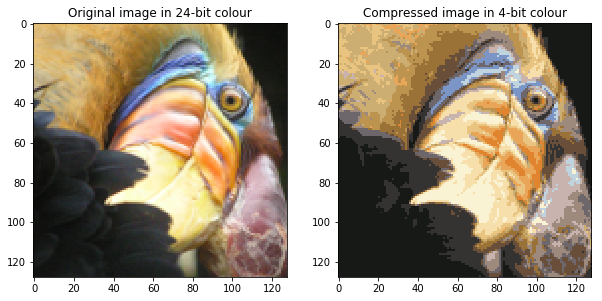

In [25]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title('Original image in 24-bit colour')
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(X_recovered)
plt.title('Compressed image in 4-bit colour')
plt.show()